## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt


In [11]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()


##save the result on disk
with open('objpoints', 'wb') as fp:
    pickle.dump(objpoints, fp)
with open('imgpoints', 'wb') as fp:
    pickle.dump(imgpoints, fp)

## Apply a distortion correction to raw images

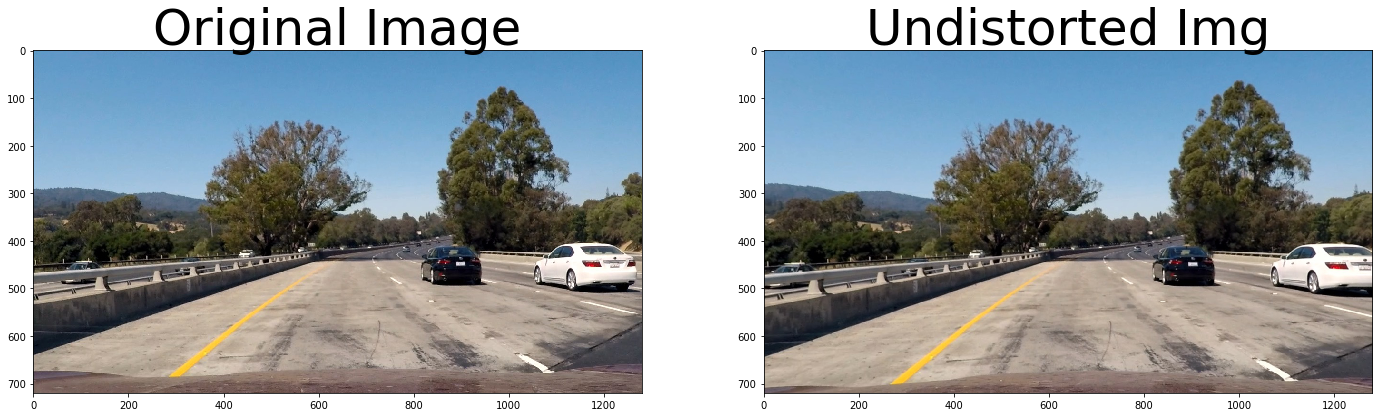

In [4]:
#load data from files
with open ('objpoints', 'rb') as fp:
    objpoints = pickle.load(fp)
with open ('imgpoints', 'rb') as fp:
    imgpoints = pickle.load(fp)



def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Img', fontsize=50)

## Use color transforms, gradients, etc., to create a thresholded binary image.

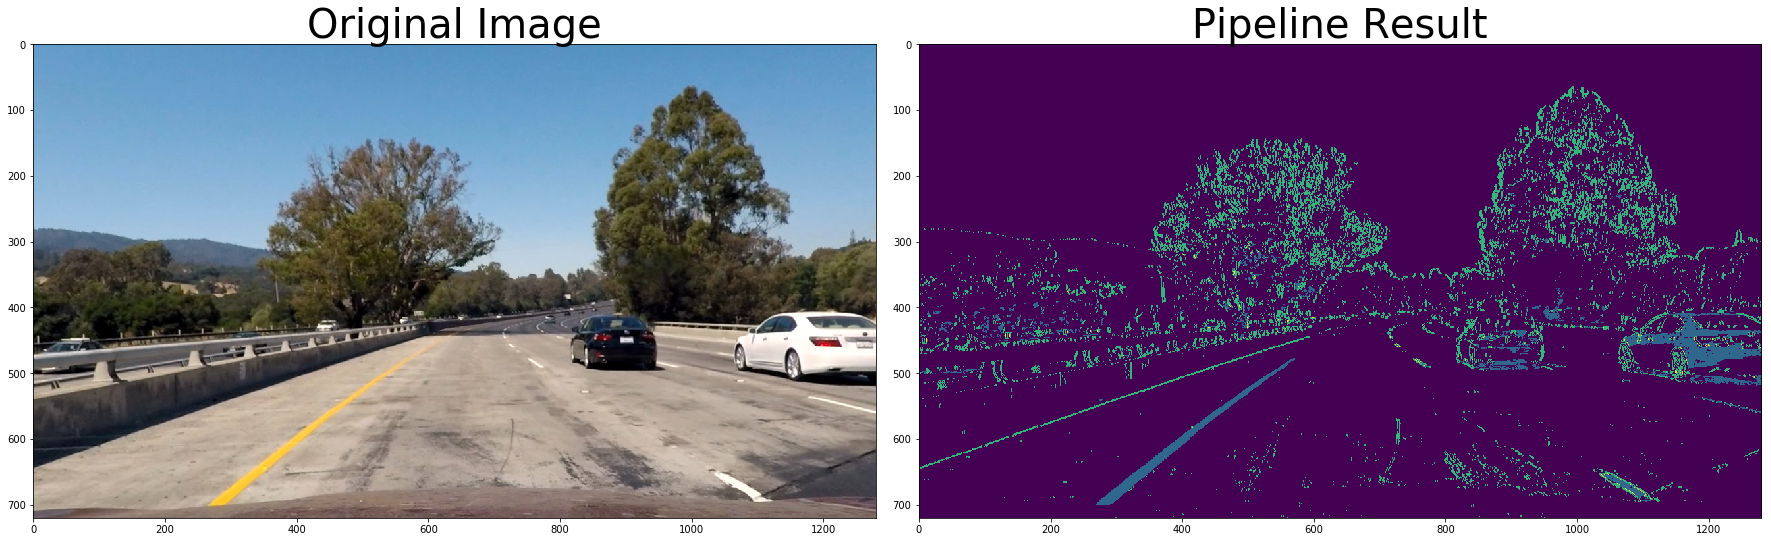

In [7]:
# Define a function that thresholds the S-channel of HLS

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    #threshold h channel
    thresh = (15, 100)
    h_binary = np.zeros_like(H)
    h_binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary, h_binary)) * 255
    #rgb_image = cv2.cvtColor(color_binary, cv2.COLOR_HLS2BGR) 
    gray_img = cv2.cvtColor(color_binary, cv2.COLOR_BGR2GRAY)
    return gray_img
    
result = pipeline(undistorted)
warped= result

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Apply a perspective transform to rectify binary image ("birds-eye view").

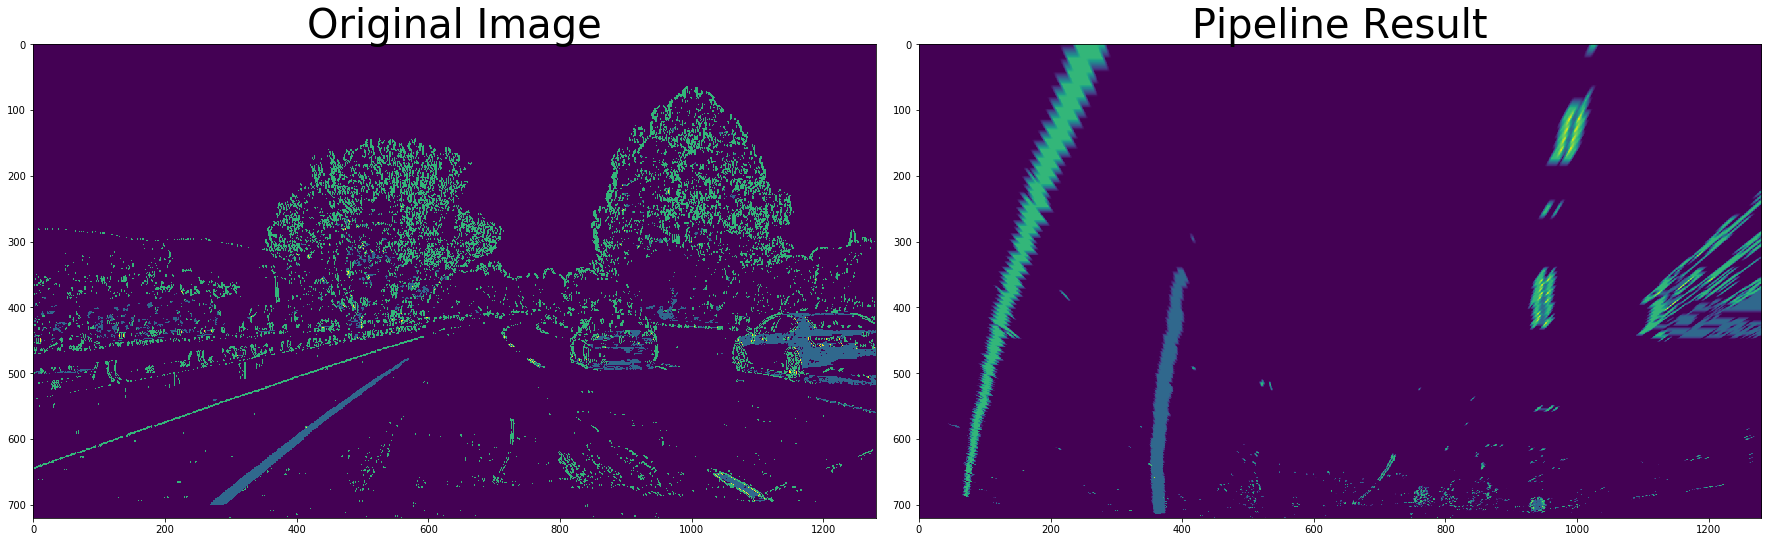

In [8]:
def warp_img(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

img_size = (img.shape[1], img.shape[0])

# define source and destination points for transform
src = np.float32([[580,450],[710,450],[1220,720],[150,720]])
dst = np.float32([[300, 0], 
                      [img_size[0]-300, 0], 
                      [img_size[0]-300, img_size[1]-0], 
                      [300, img_size[1]-0]])


img_warp, M, Minv = warp_img(result, src, dst)

# Visualize warp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(result)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(img_warp)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

In [9]:
def detect_and_fit(img_warp):
    #Assuming you have created a warped binary image called "binary_warped"
    binary_warped = img_warp
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, ploty, left_fitx, right_fitx



(720, 0)

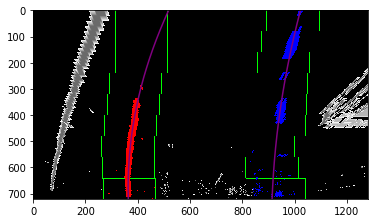

In [10]:
out_img,ploty, left_fitx, right_fitx = detect_and_fit(img_warp)


plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='purple')
plt.plot(right_fitx, ploty, color='purple')
plt.xlim(0, 1280)
plt.ylim(720, 0)
#print(len(left_fitx))
#print(len(right_fitx))
#print(len(ploty))

## draw the lane lines on the original image

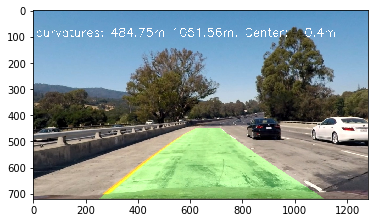

In [11]:
def draw_lines(image, undist, warped, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]),flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result, pts_left, pts_right

##radius of curvature
def radius_of_curvature(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def vehicle_from_center(img,left, right):
    pos = img.shape[1]/2
    center = (left + right)/2
    xm_per_pix = 3.7/700 
    return (pos - center)*xm_per_pix

result, pts_left, pts_right = draw_lines(undistorted, undistorted,img_warp, left_fitx, right_fitx, ploty, Minv)
left_curverad, right_curverad = radius_of_curvature(left_fitx, right_fitx, ploty)
center = vehicle_from_center(img,pts_left[len(pts_left)-1][0][0], pts_right[len(pts_right)-1][0][0])

#draw text on image
def draw_text_on_img(img, left_cur, right_cur, center):
    #https://stackoverflow.com/questions/16615662/how-to-write-text-on-a-image-in-windows-using-python-opencv2
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,100)
    fontScale              = 1.5
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(img,'curvatures: ' + str(round(left_cur, 2)) + 'm ' + str(round(right_cur, 2)) + 'm. Center: ' + str(round(center, 2))+ "m", 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    return img

result = draw_text_on_img(result, left_curverad,right_curverad, center )
plt.imshow(result)

## now process the video

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(img):
    img = cv2.copyMakeBorder(img,0,0,0,0,cv2.BORDER_REPLICATE)
    undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)
    result = pipeline(undistorted)
    img_size = (img.shape[1], img.shape[0])

    # define source and destination points for transform
    src = np.float32([[580,450],[710,450],[1220,720],[150,720]])
    dst = np.float32([[200, 0], 
                          [img_size[0]-200, 0], 
                          [img_size[0]-200, img_size[1]-0], 
                          [200, img_size[1]-0]])


    img_warp, M, Minv = warp_img(result, src, dst)
    out_img,ploty, left_fitx, right_fitx = detect_and_fit(img_warp)
    result, pts_left, pts_right = draw_lines(undistorted, undistorted,img_warp, left_fitx, right_fitx, ploty, Minv)
    left_curverad, right_curverad = radius_of_curvature(left_fitx, right_fitx, ploty)
    center = vehicle_from_center(img,pts_left[len(pts_left)-1][0][0], pts_right[len(pts_right)-1][0][0])
    result = draw_text_on_img(result, left_curverad,right_curverad, center )
    #print("processed")
    #plt.imshow(result)
    #result = result.copy()
    return result



In [13]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:25<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 14min 26s
